## MonReader

#### Background:

#### Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

#### MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.
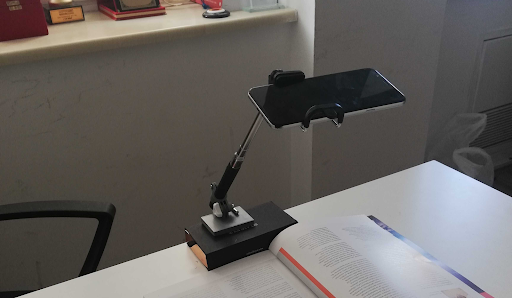
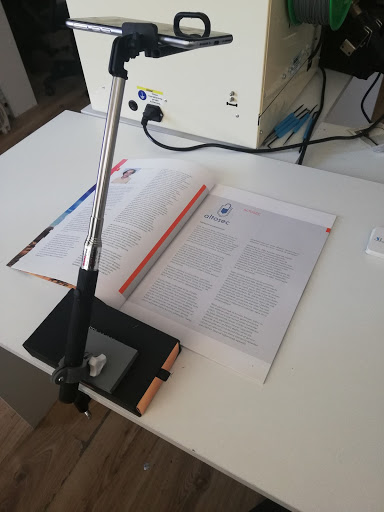
#### Data Description:

#### We collected page flipping video from smart phones and labelled them as flipping and not flipping.

#### We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

#### Goal(s):

#### Predict if the page is being flipped using a single image.

#### Success Metrics:

#### Evaluate model performance based on F1 score, the higher the better.

#### Bonus(es):

#### Predict if a given sequence of images contains an action of flipping.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading the dataset
from pathlib import Path

# Paths to the 'flip' and 'notflip' folders
flip_path = Path(r'images/training/flip')
notflip_path = Path(r"images/training/notflip")

# Get a list of JPG images in each folder
flip_images = list(flip_path.glob("*.jpg"))
notflip_images = list(notflip_path.glob("*.jpg"))

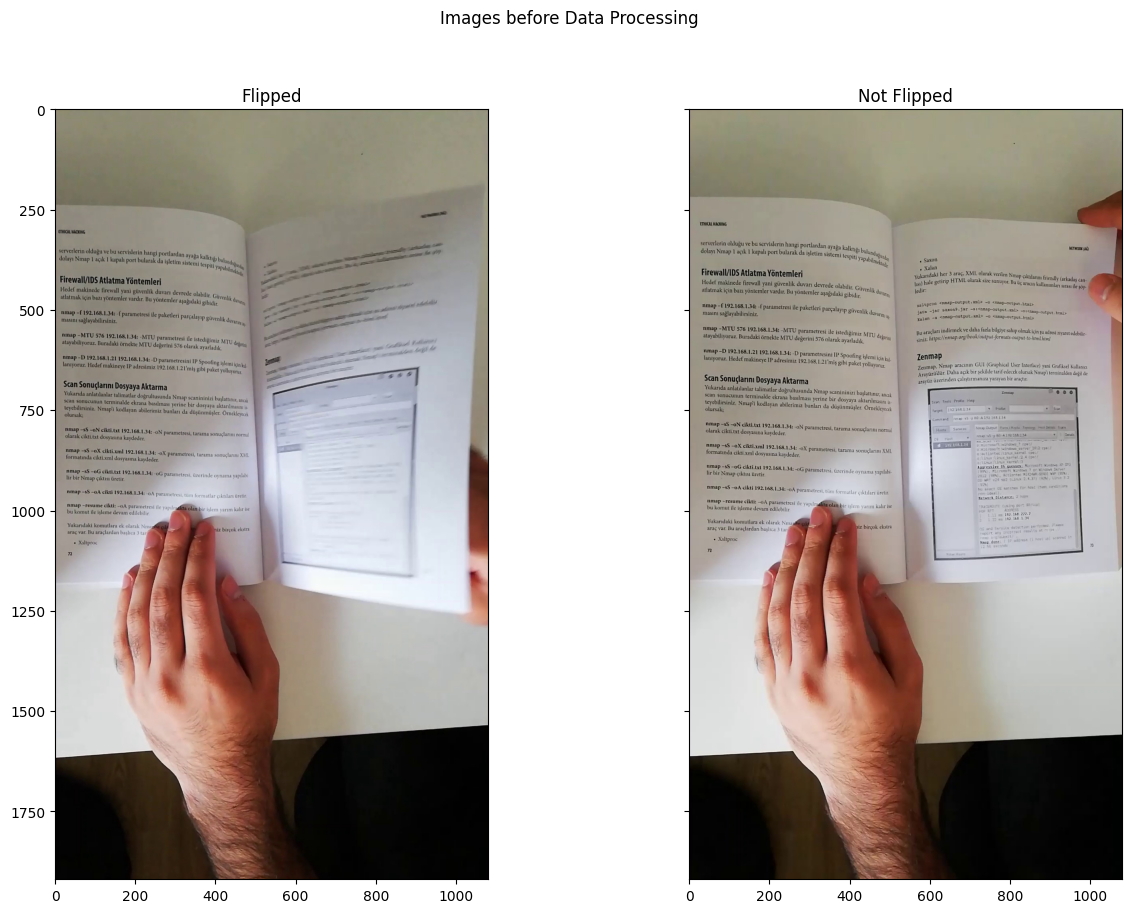

In [4]:
# Check if there are any JPEG images before trying to access them
if flip_images and notflip_images:
    # Load the first JPEG image from each folder
    flip_image = plt.imread(str(flip_images[0]))
    notflip_image = plt.imread(str(notflip_images[0]))

    # Display the images
    fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 10))

    ax[0].imshow(flip_image)
    ax[0].set_title('Flipped')

    ax[1].imshow(notflip_image)
    ax[1].set_title('Not Flipped')

    plt.suptitle('Images before Data Processing')
    plt.show()
else:
    print("No JPG images found in the specified folders.")

In [5]:
print(flip_image.shape)
print(notflip_image.shape)

(1920, 1080, 3)
(1920, 1080, 3)
